In [1]:
# !pip install datasets
# !pip install huggingface_hub

import warnings 
warnings.filterwarnings(action='ignore')

import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import image, data
from tensorflow.keras import Model, losses
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Conv2DTranspose, Activation, BatchNormalization, Concatenate

In [2]:
dataset = load_dataset('nateraw/pascal-voc-2012', split='train')

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac
Reusing dataset parquet (/aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


In [3]:
dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 2913
})

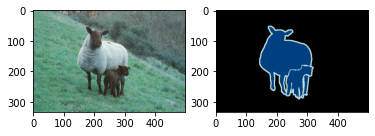

In [4]:
encoded_img = np.fromstring(dataset['image'][994]['bytes'], dtype = np.uint8)
img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
plt.subplot(121)
plt.imshow(img)

encoded_img2 = np.fromstring(dataset['mask'][994]['bytes'], dtype = np.uint8)
img2 = cv2.imdecode(encoded_img2, cv2.IMREAD_COLOR)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [5]:
print(encoded_img)
img.shape

[255 216 255 ... 143 255 217]


(333, 500, 3)

In [6]:
len(dataset[0])

2

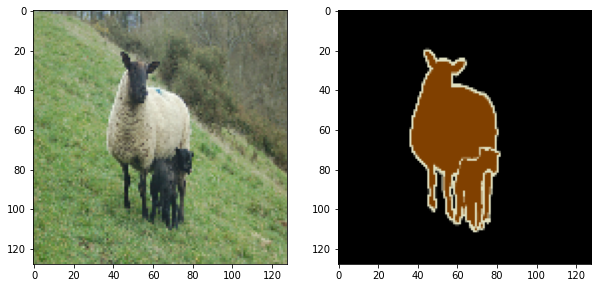

In [7]:
image_size = 128
img_shape = (image_size, image_size, 3)

def normalize(x):
    """
    이미지 정규화
    """
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    """
    정규화된 이미지 되돌리기
    """
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(i, m):
    """
    이미지 경로에서 파일을 읽어들여 인풋과 아웃풋으로 분리하고 정규화하여 반환
    """        
    i = tf.image.decode_image(i, 3)
    m = tf.image.decode_image(m, 3) 
    
    resize = [image_size, image_size]
    i = tf.image.resize(i, resize)
    m = tf.image.resize(m, resize)
    
    i = tf.cast(i, tf.float32)
    m = tf.cast(m, tf.float32)
    
    return normalize(i), normalize(m)

i, m = load_img(dataset['image'][994]['bytes'], dataset['mask'][994]['bytes'])
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(denormalize(i))
plt.subplot(1,2,2)
plt.imshow(denormalize(m))

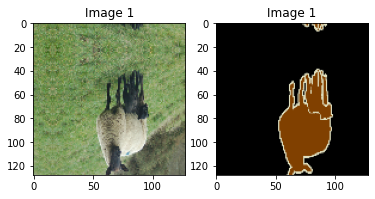

In [8]:
def augmentation(i, m):
    """
    패딩, 자르기, 반전, 회전 augmentation방법을 랜덤으로 하여 데이터 생성 
    """
    stacked = tf.concat([i, m], axis=-1)
    
    # 패딩
    _pad = tf.constant([[30,30], [30,30], [0,0]])
    
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    
    # 이미지 자르기
    out = image.random_crop(padded, size=[image_size, image_size, 6])
    
    # 반전
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    # 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

# augmentation 테스트
img_n = 1
augmented_painting, augmented_actual = augmentation(i, m)    
plt.subplot(1,2,1)
plt.imshow(denormalize(augmented_painting))
plt.title(f"Image {img_n}")

plt.subplot(1,2,+2); 
plt.imshow(denormalize(augmented_actual))
plt.title(f"Image {img_n}")
img_n += 1

In [9]:
def process_data(d_s):
    i = d_s['image']['bytes']
    m = d_s['mask']['bytes']
    i, m = load_img(i, m)
    i, m = augmentation(i, m)
#     return {'image': i, 'mask': m}
    return i, m
print(type(dataset))
# data= dataset.map(process_data, num_proc=1)
image_list = list()
mask_list = list()
for data in dataset:
    i, m = process_data(data)
    image_list.append(i)
    mask_list.append(m)
    

<class 'datasets.arrow_dataset.Dataset'>


In [10]:
print(len(image_list), len(mask_list))

2913 2913


In [11]:
DATASET_SIZE = 2913

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.29 * DATASET_SIZE)
test_size = 2913 - train_size - val_size
print(train_size, val_size, test_size)

train_image_list = image_list[:train_size]
train_mask_list = mask_list[:train_size]
val_image_list = image_list[train_size: -test_size]
val_mask_list = mask_list[train_size: -test_size]
test_image_list = image_list[-test_size:]
test_mask_list = mask_list[-test_size:]
print(len(train_image_list), len(val_image_list), len(test_image_list))

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_list, train_mask_list))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_list, val_mask_list))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_list, test_mask_list))

batch_size = 16
train_dataset = train_dataset.shuffle(100).batch(batch_size)
val_dataset = val_dataset.shuffle(50).batch(batch_size)
test_dataset = test_dataset.shuffle(10).batch(batch_size)

2039 844 30
2039 844 30


In [12]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(n_filters, 3, padding='same')
        self.conv2 = Conv2D(n_filters, 3, padding='same')

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

        self.activation = Activation('relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        return x
    
class EncoderBlock(Layer):
    def __init__(self, n_filters):
        super(EncoderBlock, self).__init__()

        self.conv_blk = ConvBlock(n_filters)
        self.pool = MaxPooling2D((2,2))

    def call(self, inputs):
        x = self.conv_blk(inputs)
        p = self.pool(x)
        return x, p
    

class DecoderBlock(Layer):
    def __init__(self, n_filters):
        super(DecoderBlock, self).__init__()

        self.up = Conv2DTranspose(n_filters, (2,2), strides=2, padding='same')
        self.conv_blk = ConvBlock(n_filters)

    def call(self, inputs, skip):
        x = self.up(inputs)
        x = Concatenate()([x, skip])
        x = self.conv_blk(x)

        return x

In [13]:
class UNet(Model):
    def __init__(self):
        super(UNet, self).__init__()
        '''
        메모리가 할당되지 못해서 인풋크기를 줄임에 따라 모델 크기도 감소시킴
        '''
        self.e1 = EncoderBlock(32)
        self.e2 = EncoderBlock(64)
        self.e3 = EncoderBlock(128)
        self.e4 = EncoderBlock(256)

        self.b = ConvBlock(512)

        self.d1 = DecoderBlock(256)
        self.d2 = DecoderBlock(128)
        self.d3 = DecoderBlock(64)
        self.d4 = DecoderBlock(32)
        
        self.outputs = Conv2D(1, 1, padding='same', activation='sigmoid')

    def call(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


In [14]:
'''
Dice loss를 추가하여 segmentation task를 더 잘 수행
Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있음
Dice Loss가 최대화되는 방향으로 구해짐
새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 Dice loss를 더하는 방식으로 구성
'''

def dice_coeff(y_true, y_pred): 
    smooth = 1e-10        
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

def dice_loss(y_true, y_pred):    
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)

    return loss

In [15]:
optimizer = tf.keras.optimizers.Adam()

loss_history = []
epochs = 30

model = UNet()

for epoch in range(epochs):
    for images, labels in train_dataset:
        with tf.GradientTape() as tape: # 모델 학습 파트
            predictions = model(images)
            loss = bce_dice_loss(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        loss_history.append([epoch, loss])
    if epoch % 5 == 0:
        print(f'epoch {epoch}, loss: {loss}')


ValueError: logits and labels must have the same shape ((16, 128, 128, 1) vs (16, 128, 128, 3))